In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier

In [9]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784
k = 10000 # кількість даних під тест


In [10]:
# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data= np.c_[(x_train), y_train]
np.random.shuffle(train_data)

train_data_X = train_data[:, :-1]
train_data_y = train_data[:, -1]

train_data_y = to_categorical(train_data_y, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [22]:
x_val = train_data_X[:k]
partial_x_train = train_data_X[k:]

y_val = train_data_y[:k]
partial_y_train = train_data_y[k:]

units = [1000, 2000, 3000]
batches = [1024, 2048]
dropouts = [0.0, 0.1, 0,2]
activations = ['relu', 'leaky_relu', 'softplus', 'gelu', 'mish', 'tanh']


def create_model(units=1000, activation='relu'):
    model = Sequential([
        Dense(units, activation=activation, input_shape=(num_features,)),
        # Dropout(0.0),
        Dense(num_classes, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

total_test_accuracy = 0
history_dict = {}
activation_ = None
unit_ = 0
batch_ = 0

for unit in units:
    
    for batch in batches:
        
        for activation in activations:
            
        
            print(f'units: {unit}, batch: {batch}, activation: {activation}')

            model = create_model(unit, activation)


            early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
            checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
            tensorboard = TensorBoard(log_dir='./logs')


            history = model.fit(
                partial_x_train,
                partial_y_train,
                epochs=150,
                batch_size=batch,
                validation_data=(x_val, y_val),
                callbacks=[checkpoint, early_stopping, tensorboard]

            )

            test_loss, test_accuracy = model.evaluate(x_test, y_test)
            print('Test loss: ', test_loss)
            print('Test accuracy: ', test_accuracy)

            if test_accuracy > total_test_accuracy:
                total_test_accuracy = test_accuracy
                history_dict = history
                activation_ = activation
                unit_ = unit
                batch_ = batch
                
                
                model.save("best_model.keras")
                model.summary()


units: 1000, batch: 1024, activation: relu
Epoch 1/150
49/49 [==============================] - 1s 22ms/step - loss: 0.7531 - accuracy: 0.7366 - val_loss: 0.5267 - val_accuracy: 0.8168
Epoch 2/150
49/49 [==============================] - 1s 16ms/step - loss: 0.4948 - accuracy: 0.8307 - val_loss: 0.4750 - val_accuracy: 0.8332
Epoch 3/150
49/49 [==============================] - 1s 16ms/step - loss: 0.4664 - accuracy: 0.8386 - val_loss: 0.4706 - val_accuracy: 0.8375
Epoch 4/150
49/49 [==============================] - 1s 16ms/step - loss: 0.4387 - accuracy: 0.8495 - val_loss: 0.4400 - val_accuracy: 0.8462
Epoch 5/150
49/49 [==============================] - 1s 15ms/step - loss: 0.4332 - accuracy: 0.8498 - val_loss: 0.4583 - val_accuracy: 0.8455
Epoch 6/150
49/49 [==============================] - 1s 15ms/step - loss: 0.4260 - accuracy: 0.8527 - val_loss: 0.4713 - val_accuracy: 0.8366
Epoch 7/150
49/49 [==============================] - 1s 16ms/step - loss: 0.4210 - accuracy: 0.8545 - val

In [27]:
model = keras.models.load_model("best_model.keras")
model.summary()
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_loss, test_accuracy)

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 3000)              2355000   
                                                                 
 dense_217 (Dense)           (None, 10)                30010     
                                                                 
Total params: 2385010 (9.10 MB)
Trainable params: 2385010 (9.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 3s 9ms/step - loss: 0.4782 - accuracy: 0.9005
0.478166401386261 0.9004999995231628


In [28]:
# Найточніша модель на параметрах:

print(f"Activation function: {activation_}, unit numbers: {unit_}, batch: {batch_}")

Activation function: mish, unit numbers: 3000, batch: 1024


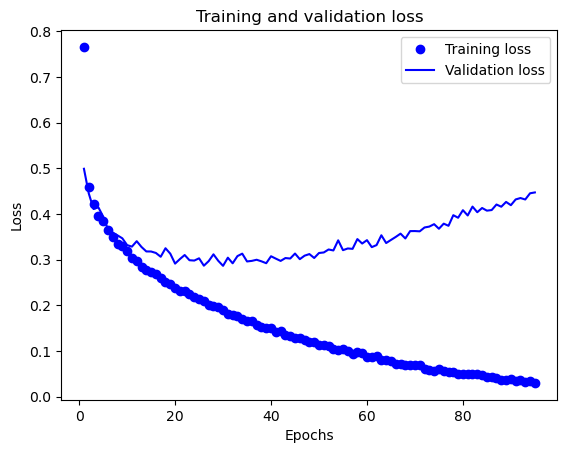

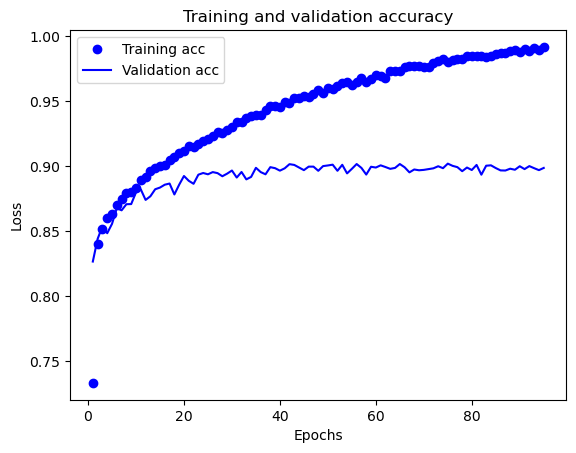

In [29]:
import matplotlib.pyplot as plt


history_dict = history_dict.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [5]:
x_val = train_data_X[:k]
partial_x_train = train_data_X[k:]

y_val = train_data_y[:k]
partial_y_train = train_data_y[k:]

def create_model(num_unit=10, dropout=0.0, activation='relu'):
    
    
    model = Sequential([
        Dense(num_unit, activation=activation, input_shape=(num_features,)),
        Dropout(dropout),
        Dense(num_classes, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f'num_units: {num_unit}, dropout: {dropout}, activation: {activation}')

    
    return model

model = KerasClassifier(model=create_model, activation='relu', dropout=0.0, num_unit=10)


dropouts = np.array([0.0, 0.1])
num_units = np.array([1000, 2000, 3000])
activations = np.array(['relu', 'leaky_relu', 'softplus', 'gelu', 'mish', 'tanh'])

early_stopping = EarlyStopping(patience=10, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

param_grid = dict(num_unit=num_units, activation=activations)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid_result = grid.fit(partial_x_train, 
                       partial_y_train, 
                       epochs=120, 
                       batch_size=2048, 
                       validation_data=(x_val, y_val), 
                       callbacks=[checkpoint, early_stopping])


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



2024-02-06 01:18:01.495420: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-06 01:18:01.495455: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-06 01:18:01.495462: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-06 01:18:01.495517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-06 01:18:01.495548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


num_units: 1000, dropout: 0.0, activation: relu
Epoch 1/120
 4/20 [=====>........................] - ETA: 0s - loss: 1.7990 - accuracy: 0.3922

2024-02-06 01:18:01.883471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 25ms/step - loss: 0.9810 - accuracy: 0.6563 - val_loss: 0.6381 - val_accuracy: 0.7756
Epoch 2/120
20/20 [==============================] - 0s 19ms/step - loss: 0.5761 - accuracy: 0.8036 - val_loss: 0.5339 - val_accuracy: 0.8188
Epoch 3/120
20/20 [==============================] - 0s 19ms/step - loss: 0.5081 - accuracy: 0.8287 - val_loss: 0.5016 - val_accuracy: 0.8289
Epoch 4/120
20/20 [==============================] - 0s 19ms/step - loss: 0.4799 - accuracy: 0.8379 - val_loss: 0.4850 - val_accuracy: 0.8337
Epoch 5/120
20/20 [==============================] - 0s 20ms/step - loss: 0.4633 - accuracy: 0.8414 - val_loss: 0.4653 - val_accuracy: 0.8427
Epoch 6/120
20/20 [==============================] - 0s 20ms/step - loss: 0.4503 - accuracy: 0.8467 - val_loss: 0.4577 - val_accuracy: 0.8467
Epoch 7/120
20/20 [==============================] - 0s 20ms/step - loss: 0.4406 - accuracy: 0.8486 - val_loss: 0.4715 - val_accuracy: 0.8407
Epoch 8/120
20/20 

In [7]:
grid_result.best_score_, grid_result.best_params_



(0.8954599999999999, {'activation': 'gelu', 'num_unit': 1000})